In [6]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from keras.utils import np_utils

In [7]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 10
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True


In [8]:
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [9]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [10]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [11]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [12]:
def resnet_v2(input_shape, depth, num_classes=10):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [14]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=adam_v2.Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 32, 32, 16)   0           batch_normalization_19[0][0]     
______________________________________________________________________

D:\Anaconda3\envs\jupyter\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

Using real-time data augmentation.


D:\Anaconda3\envs\jupyter\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
Learning rate:  0.001
1563/1563 [==============================] - 413s 263ms/step - loss: 1.5780 - accuracy: 0.4849 - val_loss: 1.6473 - val_accuracy: 0.5141
Epoch 2/10
Learning rate:  0.001
1563/1563 [==============================] - 419s 268ms/step - loss: 1.2038 - accuracy: 0.6291 - val_loss: 1.2581 - val_accuracy: 0.6181
Epoch 3/10
Learning rate:  0.001
1563/1563 [==============================] - 410s 262ms/step - loss: 1.0407 - accuracy: 0.6933 - val_loss: 1.2411 - val_accuracy: 0.6442
Epoch 4/10
Learning rate:  0.001
1563/1563 [==============================] - 405s 259ms/step - loss: 0.9379 - accuracy: 0.7317 - val_loss: 1.2117 - val_accuracy: 0.6553
Epoch 5/10
Learning rate:  0.001
1563/1563 [==============================] - 420s 269ms/step - loss: 0.8773 - accuracy: 0.7544 - val_loss: 1.0999 - val_accuracy: 0.6950
Epoch 6/10
Learning rate:  0.001
1563/1563 [==============================] - 411s 263ms/step - loss: 0.8280 - accuracy: 0.7728 - val_loss: 1.0339 - v

In [ ]:
# here add plot to show history result for resnetv1

In [17]:
version = 2

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=adam_v2.Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()


##################


save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history2 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)



Learning rate:  0.001
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 32, 32, 16)   64          conv2d_64[0][0]                  
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 32, 32, 16)   0           batch_normalization_57[0][0]     
______________________________________________________________________

D:\Anaconda3\envs\jupyter\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
D:\Anaconda3\envs\jupyter\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
Learning rate:  0.001
1563/1563 [==============================] - 554s 353ms/step - loss: 1.7441 - accuracy: 0.4909 - val_loss: 1.7800 - val_accuracy: 0.5277
Epoch 2/10
Learning rate:  0.001
1563/1563 [==============================] - 539s 345ms/step - loss: 1.3329 - accuracy: 0.6235 - val_loss: 1.4610 - val_accuracy: 0.5841
Epoch 3/10
Learning rate:  0.001
1563/1563 [==============================] - 540s 346ms/step - loss: 1.1545 - accuracy: 0.6799 - val_loss: 1.7948 - val_accuracy: 0.5308
Epoch 4/10
Learning rate:  0.001
1563/1563 [==============================] - 541s 346ms/step - loss: 1.0397 - accuracy: 0.7204 - val_loss: 1.0897 - val_accuracy: 0.7087
Epoch 5/10
Learning rate:  0.001
1563/1563 [==============================] - 533s 341ms/step - loss: 0.9771 - accuracy: 0.7444 - val_loss: 1.2546 - val_accuracy: 0.6642
Epoch 6/10
Learning rate:  0.001
1563/1563 [==============================] - 526s 337ms/step - loss: 0.9222 - accuracy: 0.7604 - val_loss: 0.9734 - v

In [21]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 32, 32, 16)   64          conv2d_64[0][0]                  
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 32, 32, 16)   0           batch_normalization_57[0][0]     
____________________________________________________________________________________________

In [18]:
# show history and history2 plots
# 搞定，画图，显示训练集和验证集的acc和loss曲线
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


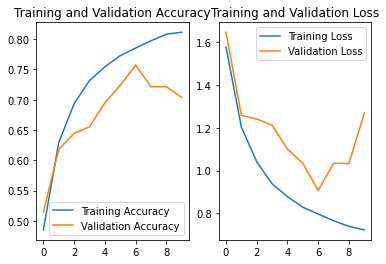

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

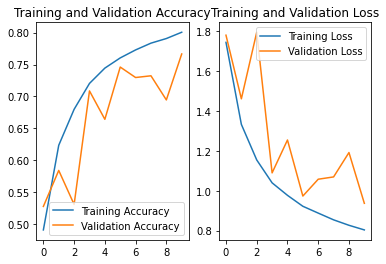

In [20]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()